# CoViD19 Modeling notebook 
* Carsten Fortmann-Grote
* Johannes Zierenberg
* Hans Fangohr

## Abstract
This jupyter notebook demonstrates bayesian inference of model parameters (SRI model) from CoViD19 case data for Germany. Original version at https://github.com/zierenberg/covid19_inference_forecast .

## Table of Contents
* [Setting up the environment](#Import-required-python-modules)
* [Modeling](#Modeling)
  * [Model setup](#Model-setup)
  * [Model training](#Model-training)
  * [Results](#Results)

In [1]:
try:
    import copy
    import datetime
    import logging
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import pickle
    import pymc3 as pm
    import scipy.stats
    import seaborn
    import sys
    import theano
    import theano.tensor as tt
    import time
    from sri_utilities import *
    from IPython.display import Markdown as md  
    logging.basicConfig(level=logging.WARNING)
    logging.info("Sucessfully imported all modules.")
    
except ModuleNotFoundError as e:
    logging.error("One or more modules could not be imported. Please make sure all modules listed in this code cell are properly installed. Run `pip install <module_name>` or `conda install -c conda-forge <module_name>` for all modules that cannot be found.")
    raise

## Loading the data

The data we are using are the confirmed COVID-19 cases aggregated by the Johns Hopkins University https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

#### Path to data files (URL)

In [2]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#### Read the data using `pandas.read_csv()`

In [3]:
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths = pd.read_csv(deaths_url, sep=',')

# Modeling

### Select time range and country

In [4]:
date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,3,15)
num_days_to_predict = 28

In [5]:
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

In [6]:
cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

In [7]:
#cases_obs = np.concatenate([np.nan*np.ones(diff_data_sim), cases_obs])
print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = (date_data_end - date_begin_sim).days
date_today = date_data_end + datetime.timedelta(days=1)

Cases yesterday (2020-03-15): 5795 and day before yesterday: 4585


## Model setup
### The SIR model:
$N = S + I + R = \textrm{const}$  
Susceptibles: $\frac{dS}{dt} =-\lambda \frac{SI}{N}$   
Infected: $\frac{dI}{dt} = \lambda\frac{SI}{N} -\mu I$  

$\lambda$: infection rate  
$\mu$: recovery rate  

In [8]:
def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

In [9]:
# Set a random seed.
np.random.seed(0)

## Model training

### Specify prior distributions

We model the prior recovery rate and infection rate as
[Log normal distributions](https://en.wikipedia.org/wiki/Log-normal_distribution).  
Parameters of the distribution are the max. location $\mu$ and the width parameter $\sigma$. For the recovery rate $\mu$, we choose

In [11]:
μ_μ = 1./8
σ_μ = 0.2

and for the infection rate $\lambda$, we choose

In [12]:
μ_λ = 0.4
σ_λ = 0.5


In [13]:
# Simplified model: only early phase, no interventions
def train_model():
    """ Train the model with initial guesses for mean and fwhm parameters on recovery rate μ and infection rate λ.
    """
    
    with pm.Model() as model:
        # specify priors

        ## true cases at begin of loaded data but we do not know the real number
        I_begin = pm.HalfCauchy('I_begin', beta=100)

        ## fraction of people that are newly infected each day
        λ = pm.Lognormal("λ", mu=np.log(μ_λ), sigma=σ_λ)

        ## fraction of people that recover each day, recovery rate mu
        μ = pm.Lognormal('μ', mu=np.log(μ_μ), sigma=σ_μ)

        ## delay in days between contracting the disease and being recorded
        delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

        ## prior of the error of observed cases
        σ_obs = pm.HalfCauchy("σ_obs", beta=10)

        N_germany = 83e6

        # -------------------------------------------------------------------------- #
        # training the model with loaded data
        # -------------------------------------------------------------------------- #

        S_begin = N_germany - I_begin
        S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                                   S_begin=S_begin, I_begin=I_begin,
                                                   N=N_germany)
        new_cases_obs = np.diff(cases_obs)
        new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                         len_new_cases_obs=len(new_cases_obs), 
                                         delay=delay, delay_arr=diff_data_sim)

        # Approximates Poisson
        # calculate the likelihood of the model:
        # observed cases are distributed following studentT around the model
        pm.StudentT(
            "obs",
            nu=4,
            mu=new_cases_inferred,
            sigma=(new_cases_inferred)**0.5 * σ_obs,
            observed=new_cases_obs)  

        S_past = pm.Deterministic('S_past', S_past)
        I_past = pm.Deterministic('I_past', I_past)
        new_I_past = pm.Deterministic('new_I_past', new_I_past)
        new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)


        time_beg = time.time()
        trace = pm.sample(draws=2000, tune=800, chains=2, return_inferencedata=False)
        print("Model run in {:.2f} s".format(time.time() - time_beg))
    
    return trace

## Results

## Function for plotting the results.

In [14]:
def make_plots(cases_obs, trace):
    """ Generate plots from the model
    :param cases_obs: Observed case numbers
    :type  cases_obs: pandas.Series
    
    :param trace: Data structure returned from pymc3 model training `pm.sample()`
    :type  trace: pymc3.MultiTrace
    
    """
    #Definitions
    letter_size = 15
    ci_location = [0.95,0.9]
    alpha_texbox = 0.3
    font_text = 10

    # set figure aspect 
    len1 = 5
    len2 = 3

    # figure arangement
    fig = plt.figure(figsize=(9,10),constrained_layout=True)
    gs = fig.add_gridspec(12,11)

    ax_cases_new = fig.add_subplot(gs[0:len1,0:len1])
    ax_cases_total = fig.add_subplot(gs[len1:2*len1,0:len1])

    ax_param_infection  = fig.add_subplot(gs[0:len2,len1:len1+len2])
    ax_param_recovery = fig.add_subplot(gs[0:len2,len1+len2:len1+2*len2])

    ax_param_izero = fig.add_subplot(gs[len2:2*len2,len1:len1+len2])
    ax_param_delay = fig.add_subplot(gs[len2:2*len2,len1+len2:len1+2*len2])

    ax_param_width = fig.add_subplot(gs[2*len2:3*len2,len1:len1+len2])
    ax_param_effective_rate = fig.add_subplot(gs[2*len2:3*len2,len1+len2:len1+2*len2])

    #Plots things
    pos_letter = (-0.2, 1)

    # new cases 
    ax = ax_cases_new
    ttime = np.arange(-len(cases_obs)+1, 0)
    mpl_dates = conv_time_to_mpl_dates(ttime, date_data_end) 
    start_date, end_date = mpl_dates[0], mpl_dates[-1]
    ax.plot(mpl_dates, np.diff(cases_obs), 'd', markersize=6, label='Data')
    percentiles = np.percentile(trace.new_cases_past, q=2.5, axis=0), np.percentile(trace.new_cases_past, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(trace.new_cases_past, axis=0),color='tab:orange', label='Fit (with 95% CI)', lw=3)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    ax.set_yscale('log')
    ax.set_ylabel('Number of new cases')
    ax.set_xlabel('Date')
    ax.legend()
    ax.text(pos_letter[0], pos_letter[1], "A", transform=ax.transAxes, size=letter_size)
    ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
    ax.set_xlim(start_date, end_date)

    # cumulative new cases
    ax = ax_cases_total
    ax.plot(mpl_dates, cases_obs[1:], 'd', markersize=6, label='Data')
    cum_cases = np.cumsum(trace.new_cases_past, axis=1) + cases_obs[0]
    percentiles = np.percentile(cum_cases, q=2.5, axis=0), np.percentile(cum_cases, q=97.5, axis=0)
    ax.plot(mpl_dates, np.median(cum_cases, axis=0),color='tab:orange', label='Fit (with 95% CI)', lw=3)
    ax.fill_between(mpl_dates, percentiles[0], percentiles[1], alpha=0.3, color='tab:orange')
    ax.set_yscale('log')
    ax.set_ylabel('Total number of cases')
    ax.set_xlabel('Date')
    ax.text(pos_letter[0], pos_letter[1], "B", transform=ax.transAxes, size=letter_size)
    ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%-m/%-d'))
    ax.set_xlim(start_date, end_date)

    # posterior lambda
    ax = ax_param_infection
    ax.hist(trace.λ, bins=50, density=True, color='tab:orange',
            label='Posterior')
    limits = ax.get_xlim()
    x = np.linspace(*limits, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x, scale=μ_λ, s=σ_λ), label='Prior',
            color='tab:blue', linewidth=3)
    ax.set_xlim(*limits)
    ax.set_ylabel('Density')
    ax.set_xlabel('Infection rate $\lambda$')
    text = print_median_CI(trace.λ, prec=2)
    ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
          verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
    ax.text(pos_letter[0], pos_letter[1], "D", transform=ax.transAxes, size=letter_size)

    # posterior mu
    ax = ax_param_recovery
    ax.hist(trace.μ, bins=50, density=True, color='tab:orange',
            label='Posterior')
    limits = ax.get_xlim()
    x = np.linspace(*limits, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x, scale=μ_μ, s=σ_μ), label='Prior',
            color='tab:blue', linewidth=3)
    ax.set_xlim(*limits)
    ax.set_ylabel('Density')
    ax.set_xlabel('Recovery rate $\mu$')
    text = print_median_CI(trace.μ, prec=2)
    ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
          verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
    ax.text(pos_letter[0], pos_letter[1], "E", transform=ax.transAxes, size=letter_size)

    # posterior lambda prime
    ax = ax_param_effective_rate
    ax.locator_params(nbins=5)
    ax.hist((trace.λ - trace.μ)*100, bins=50, color='tab:orange')
    ax.set_xlabel('Eff. growth rate $\lambda^* = \lambda - \mu$ (%)')
    ax.set_ylabel('Number of Monte-Carlo samples')
    text = print_median_CI((trace.λ - trace.μ)*100, prec=0)
    ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
          verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
    ax.text(pos_letter[0], pos_letter[1], "F", transform=ax.transAxes, size=letter_size)

    # posterior delay
    ax = ax_param_delay
    ax.hist(trace.delay, bins=50, density=True, color='tab:orange',
            label='Posterior')
    limits = ax.get_xlim()
    x = np.linspace(*limits, num=100)
    ax.plot(x, scipy.stats.lognorm.pdf(x, scale=8, s=0.2), label='Prior',
            color='tab:blue', linewidth=3)
    ax.set_xlim(*limits)
    ax.set_ylabel('Density')
    ax.set_xlabel('Delay $D$')
    text = print_median_CI(trace.delay, prec=1)
    ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
          verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
    #ax.legend(loc='upper right')
    ax.text(pos_letter[0], pos_letter[1], "G", transform=ax.transAxes, size=letter_size)

    # posterior sigma
    ax = ax_param_width
    ax.hist(trace.σ_obs, bins=50, color='tab:orange', density=True, label='Posterior')
    ax.set_ylabel('Density')
    ax.set_xlabel("Width $\sigma$ of Student's t")
    limits = ax.get_xlim()
    x = np.linspace(*limits, num=100)
    ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=10), label='Prior',
            color='tab:blue', linewidth=3)
    ax.set_xlim(*limits)
    text = print_median_CI(trace.σ_obs, prec=1)
    ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
          verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
    ax.text(pos_letter[0], pos_letter[1], "H", transform=ax.transAxes, size=letter_size)

    # posterior initial number infections
    ax = ax_param_izero
    ax.hist(trace.I_begin, bins=50, color='tab:orange', density=True, label='Posterior')
    ax.set_ylabel('Density')
    ax.set_xlabel('Number of infections at begin $I_0$')
    limits = ax.get_xlim()
    x = np.linspace(*limits, num=5000)
    ax.plot(x, scipy.stats.halfcauchy.pdf(x, scale=100), label='Prior',
           color='tab:blue', linewidth=3)
    ax.set_xlim(*limits)
    ax.set_xlim(0)
    text = print_median_CI(trace.I_begin, prec=0)
    ax.text(ci_location[0], ci_location[1], text, horizontalalignment='right',
         verticalalignment='top', transform=ax.transAxes,  bbox=dict(facecolor='white', alpha=alpha_texbox,edgecolor='none'),fontsize=font_text)
    ax.legend(loc='lower right')
    ax.text(pos_letter[0], pos_letter[1], "I", transform=ax.transAxes, size=letter_size)

    # Removes ylabels from D-I
    ax_params = [ax_param_infection,ax_param_recovery, ax_param_effective_rate, ax_param_delay,ax_param_width,ax_param_izero]
    for ax in ax_params:
        ax.set_yticks([])
        ax.set_ylabel('')
    
    return fig

In [15]:
# Run the model
traces = train_model()

/opt/anaconda3/envs/theano-pymc3/lib/python3.9/site-packages/theano/gpuarray/dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [σ_obs, delay, μ, λ, I_begin]
INFO:pymc3:NUTS: [σ_obs, delay, μ, λ, I_begin]


Sampling 2 chains for 800 tune and 2_000 draw iterations (1_600 + 4_000 draws total) took 68 seconds.
INFO:pymc3:Sampling 2 chains for 800 tune and 2_000 draw iterations (1_600 + 4_000 draws total) took 68 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


Model run in 79.27 s


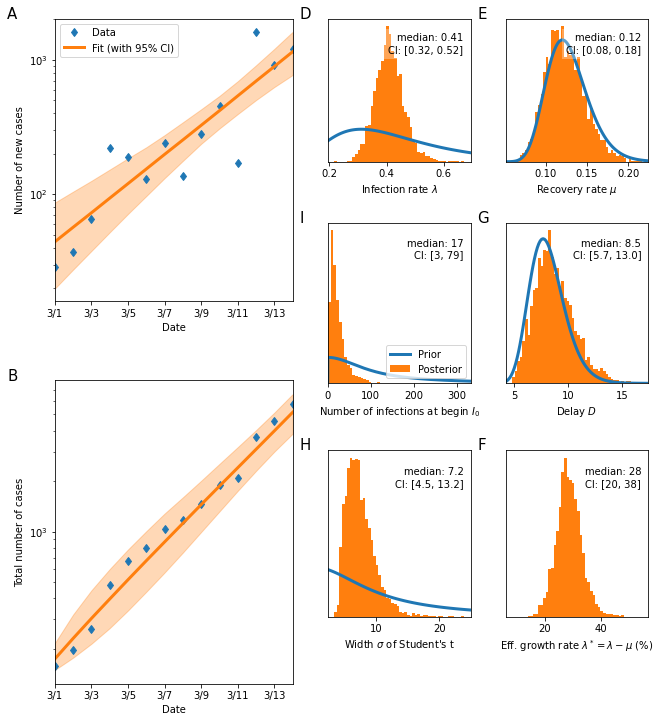

In [17]:
make_plots(cases_obs, traces)
plt.show()

### Exercise:
* Change the prior distribution for recovery rate $\mu$ to be peaked at
1/8 instead of 1/6.
* Observe the change in the posterior distribution for lambda
* Document your observation in a markdown cell.

In [19]:
# Run the model with changed initial guesses for \mu
μ_μ = 1./6
traces = train_model()

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [σ_obs, delay, μ, λ, I_begin]
INFO:pymc3:NUTS: [σ_obs, delay, μ, λ, I_begin]


Sampling 2 chains for 800 tune and 2_000 draw iterations (1_600 + 4_000 draws total) took 67 seconds.
INFO:pymc3:Sampling 2 chains for 800 tune and 2_000 draw iterations (1_600 + 4_000 draws total) took 67 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Model run in 76.41 s


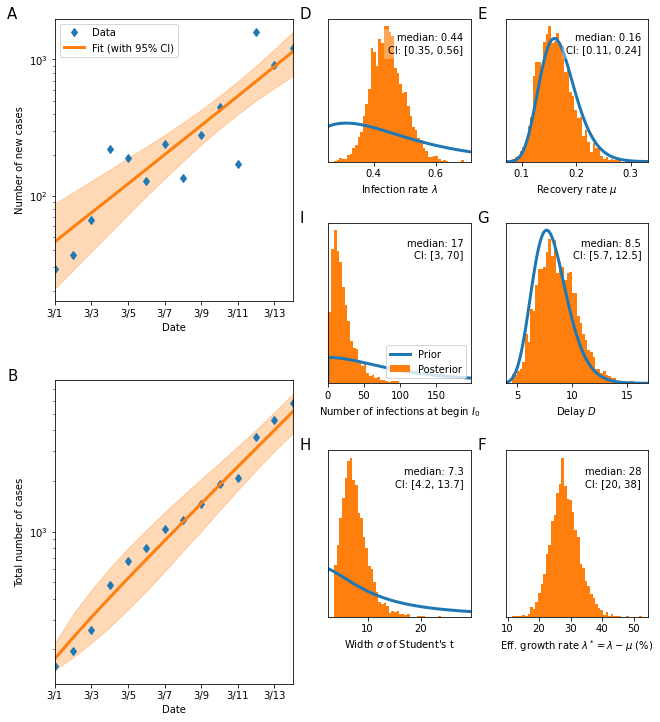

In [20]:
make_plots(cases_obs, traces)
plt.show()

### Interpretation
During the initial (exponential) phase of the pandemic, the case numbers are characterized by one single parameter, the *effective* growth rate $\lambda^* = \lambda - \mu$. Increasing the peak position of the prior on $\mu$ will hence force an increase in $\lambda$ by the same amount, such that the difference remains constant.